In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [48]:
data = pd.read_csv("NHS_Data_Final_Cleaned.csv")
data.shape
data.columns
data = data.iloc[:,:-1]
data.columns
data.shape

(41846, 85)

In [49]:
data['site_national_code'].value_counts()

site_national_code
RRF02    28833
RRF01     6616
RRF53     6350
RRF70       47
Name: count, dtype: int64

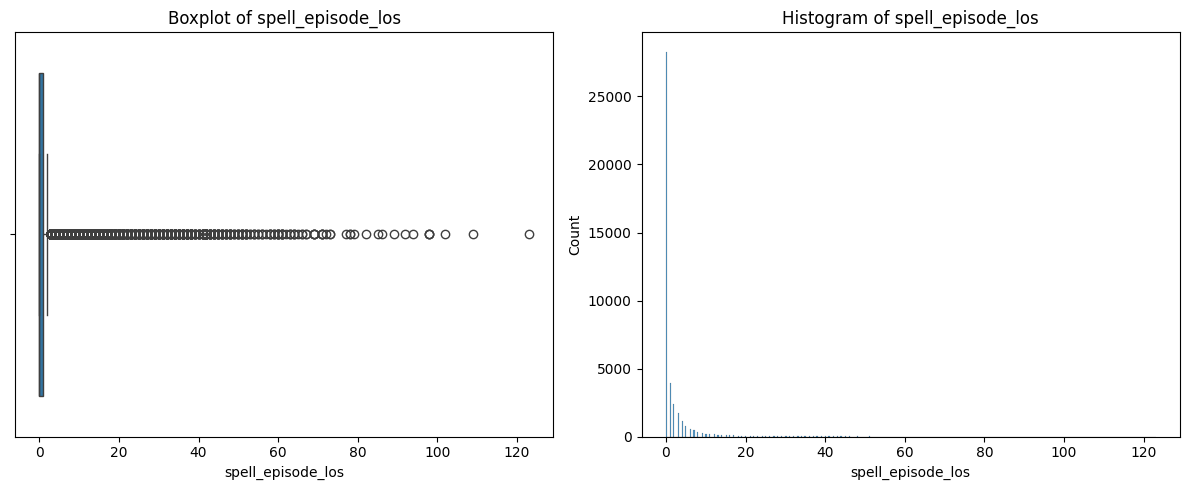

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(x=data['spell_episode_los'], ax=axes[0])
axes[0].set_title('Boxplot of spell_episode_los')

# Histogram
sns.histplot(x=data['spell_episode_los'], ax=axes[1], kde=False)
axes[1].set_title('Histogram of spell_episode_los')

plt.tight_layout()
plt.show()


Since the target variable LOS is skewed, we'll first log encode it

In [51]:
data['spell_episode_los'] = np.log(1+data['spell_episode_los'])

plotting the data after logarithmic encoding

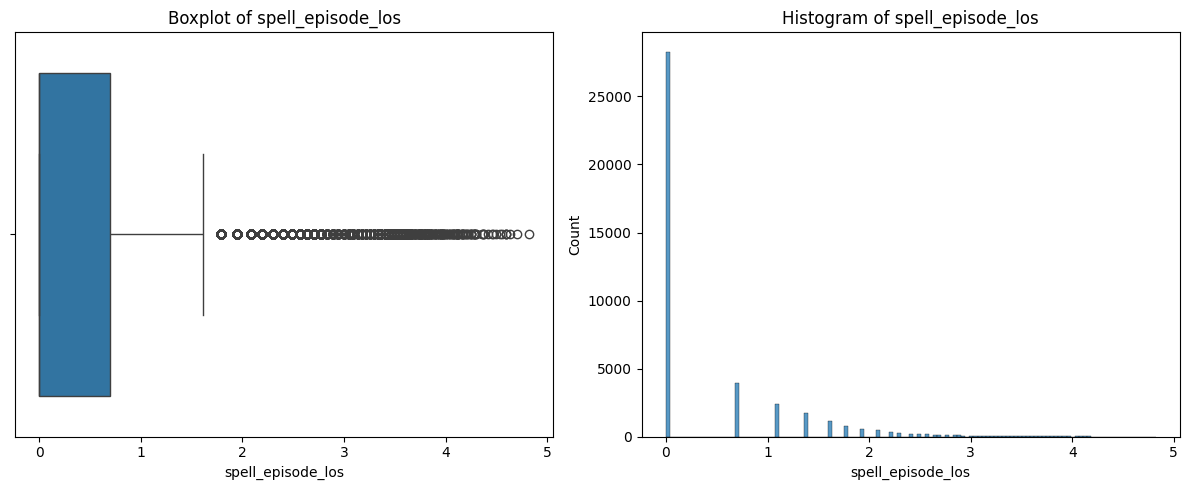

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(x=data['spell_episode_los'], ax=axes[0])
axes[0].set_title('Boxplot of spell_episode_los')

# Histogram
sns.histplot(x=data['spell_episode_los'], ax=axes[1], kde=False)
axes[1].set_title('Histogram of spell_episode_los')

plt.tight_layout()
plt.show()


<h2> Filter According to the Sites </h2>

In [4]:
data['site_national_code'].value_counts()

site_national_code
RRF02    28833
RRF01     6616
RRF53     6350
RRF70       47
Name: count, dtype: int64

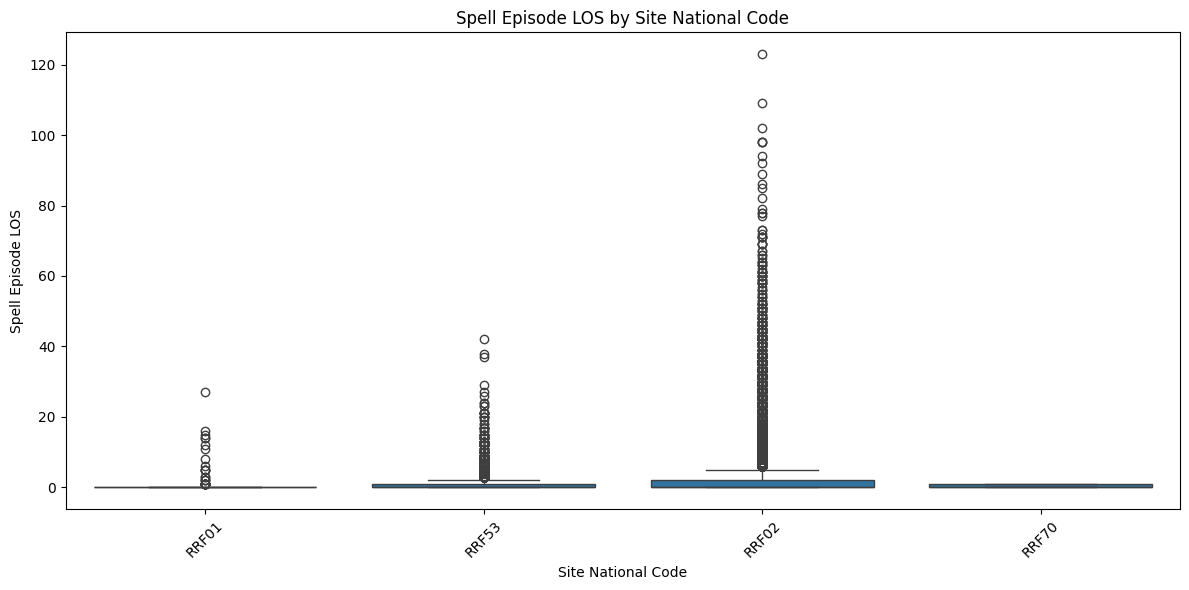

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=data,
    x='site_national_code',
    y='spell_episode_los'
)

plt.title("Spell Episode LOS by Site National Code")
plt.xlabel("Site National Code")
plt.ylabel("Spell Episode LOS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
print(data[data['site_national_code'] == 'RRF01']['spell_episode_los'].value_counts())
print(data[data['site_national_code'] == 'RRF53']['spell_episode_los'].value_counts())
print(data[data['site_national_code'] == 'RRF02']['spell_episode_los'].value_counts())
print(data[data['site_national_code'] == 'RRF70']['spell_episode_los'].value_counts())

spell_episode_los
0     6583
1       15
5        4
2        3
14       2
3        2
6        1
16       1
27       1
15       1
8        1
11       1
12       1
Name: count, dtype: int64
spell_episode_los
0     4357
2      537
1      435
3      412
4      203
5      117
6       77
7       60
8       52
9       20
10      12
12      12
13       9
14       6
21       6
15       6
11       5
17       5
20       4
24       2
16       2
18       2
23       2
42       1
27       1
26       1
29       1
38       1
37       1
19       1
Name: count, dtype: int64
spell_episode_los
0     17331
1      3451
2      1888
3      1293
4       925
      ...  
77        1
57        1
94        1
92        1
65        1
Name: count, Length: 85, dtype: int64
spell_episode_los
0    29
1    18
Name: count, dtype: int64


<h3>Model to Predict if Patient is an Outlier or not </h3>
So first we're making a model for outliers, hence we'll drop RRF70 since there's no outliers there

<b>First Classifier for RRF01

In [7]:
data_RRF01 = data[data['site_national_code']== 'RRF01']
print(data_RRF01.shape)
print(data_RRF01.columns)

(6616, 85)
Index(['acuity_code', 'Deprivation Decile', 'duration_elective_wait',
       'ethnic_origin_description', 'frailty_score', 'NEWS2',
       'patient_age_on_admission', 'patient_age_on_discharge',
       'sex_national_code', 'Admission_Date', 'admission_date_dt',
       'ae_unplanned_attendance', 'Arrival_Date', 'arrival_date_time',
       'arrival_mode_description', 'attend_dis_description', 'attendancetype',
       'initial_assessment_date_time', 'IP_admission', 'IP_discharge',
       'is_elective_flag', 'discharge_date_dt',
       'chronic_condition_asthma_flag',
       'chronic_condition_cardiovascular_disease_flag',
       'chronic_condition_diabetes_flag',
       'chronic_condition_hypertension_flag', 'chronic_condition_obesity_flag',
       'chronic_condition_respiratory_flag',
       'comorbidity_acute_myocardial_infarction_flag',
       'comorbidity_cancer_flag',
       'comorbidity_cerebral_vascular_accident_flag',
       'comorbidity_congestive_heart_failure_flag',


<b> Calculating upper and lower limit using quantiles since the data is skewed <b>

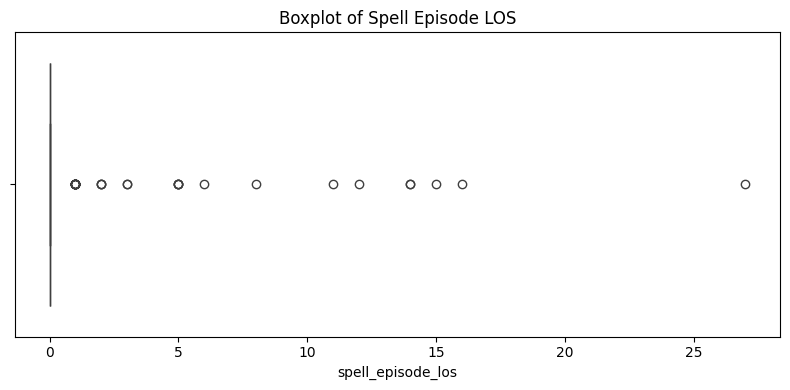

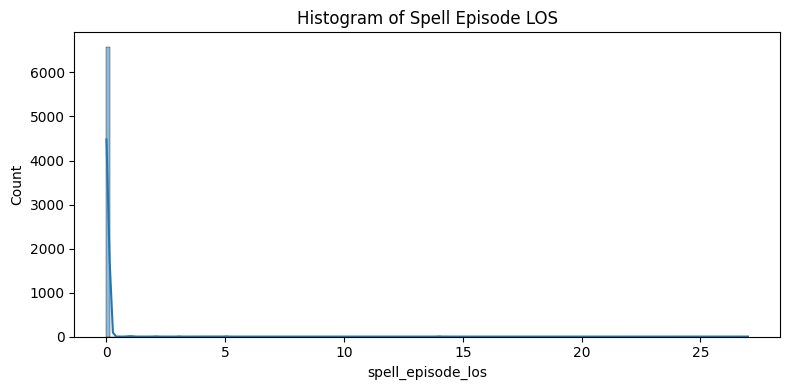

In [8]:
# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=data_RRF01['spell_episode_los'])
plt.title("Boxplot of Spell Episode LOS")
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(data_RRF01['spell_episode_los'], kde=True)
plt.title("Histogram of Spell Episode LOS")
plt.tight_layout()
plt.show()


In [9]:
lower_q = data_RRF01['spell_episode_los'].quantile(0.25)
upper_q = data_RRF01['spell_episode_los'].quantile(0.75)

IQR = upper_q - lower_q

lower_limit = lower_q - 1.5 * IQR
upper_limit = upper_q + 1.5 * IQR

outlier_perc = (
    ((data_RRF01['spell_episode_los'] < lower_limit) | 
     (data['spell_episode_los'] > upper_limit))
    .mean() * 100
)
print("lower limit is", lower_limit)
print("upper limit is", upper_limit)
print(f"percentage of outliers is {outlier_perc}")

lower limit is 0.0
upper limit is 0.0
percentage of outliers is 0.07886058404626488


As its quite evident the data is quite skewed towards 0, with almost most of the patients staying under a day. But our job is to predict the one's who stay longer. Or in other words, make the <b> <i> Recall </i></b> highest

First, we'll build a classifier that assigns patients based on if they'll stay a day longer or not

<H4><I>INSERT NATHAN'S CODE<H4>

Next We make a regression model. For outliers only, since for the hours nathan has done

In [10]:
outliers_df = data_RRF01[
    (data_RRF01['spell_episode_los'] < lower_limit) |
    (data_RRF01['spell_episode_los'] > upper_limit)
]

In [11]:
outliers_df.shape

(33, 85)

In [ ]:
# Define Categories
categories = {
    "Patient Demographics": [
        'ethnic_origin_description', 'patient_age_on_admission', 'patient_age_on_discharge',
        'sex_national_code', 'general_medical_practice_desc', 'Deprivation Decile','spell_episode_los'
    ],
    "Hospital Demographics": [
        'site_national_code', 'specialty_spec_code', 'ward_code_admission', 'ward_code_discharge',
        'specialty_division', 'specialty_directorate', 'hrg_group', 'hrg_sub_group',
        'ward_type_admission', 'ward_type_discharge', 'location', 'IP_admission', 'IP_discharge',
        'arrival_mode_description', 'source_of_ref_description', 'place_of_incident','spell_episode_los'
    ],
    "Times & Dates": [
        'Admission_Date', 'admission_date_dt', 'discharge_date_dt', 'duration_elective_wait',
        'spell_days_elective', 'spell_days_non_elective',
        'Arrival_Date', 'arrival_date_time', 'initial_assessment_date_time', 
        'delayed_discharges_no_of_days'
    ],
    "Clinical & Medical": [
    'acuity_code',
    'attend_dis_description',
    'chronic_condition_asthma_flag',
    'chronic_condition_cardiovascular_disease_flag',
    'chronic_condition_diabetes_flag',
    'chronic_condition_hypertension_flag',
    'chronic_condition_obesity_flag',
    'chronic_condition_respiratory_flag',
    'comorbidity_acute_myocardial_infarction_flag',
    'comorbidity_cancer_flag',
    'comorbidity_cerebral_vascular_accident_flag',
    'comorbidity_congestive_heart_failure_flag',
    'comorbidity_conncective_tissue_disorder_flag',
    'comorbidity_dementia_flag',
    'comorbidity_diabetes_complications_flag',
    'comorbidity_diabetes_flag',
    'comorbidity_hiv_flag',
    'comorbidity_liver_disease_flag',
    'comorbidity_metastatic_cancer_flag',
    'comorbidity_paraplegia_flag',
    'comorbidity_peptic_ulcer_flag',
    'comorbidity_peripheral_vascular_disease_flag',
    'comorbidity_pulmonary_disease_flag',
    'comorbidity_renal_disease_flag',
    'comorbidity_score',
    'comorbidity_severe_liver_disease_flag',
    'covid19_diagnosis_flag',
    'dementia_diagnosis_flag',
    'frailty_score',
    'inj_or_ail',
    'is_NEWS2_flag',
    'NEWS2',
    'presenting_complaint',
    'spell_dominant_proc',
    'spell_dominant_proc_description',
    'spell_episode_los',
    'spell_primary_diagnosis',
    'spell_secondary_diagnosis'
],
    "Outcomes & Flags": [
        'discharge_delay_reason_description', 'delayed_discharges_flag', 'readmission_flag_28_days',
        'readmission_flag_30_days', 'inpatient_death_flag', 'elective_admission_flag',
        'non_elective_admission_flag', 'emergency_readmission_non_pbr_30',
        'readmission_flag_28_days_emergancy', 'readmission_flag_30_days_emergancy',
        'medically_optimised', 'attendancetype', 'ae_unplanned_attendance', 'is_elective_flag','spell_episode_los'
    ]
}

<h3>Spell_Episode_Los for RRF01 more Outlier Analysis for model

<Axes: xlabel='spell_episode_los', ylabel='Count'>

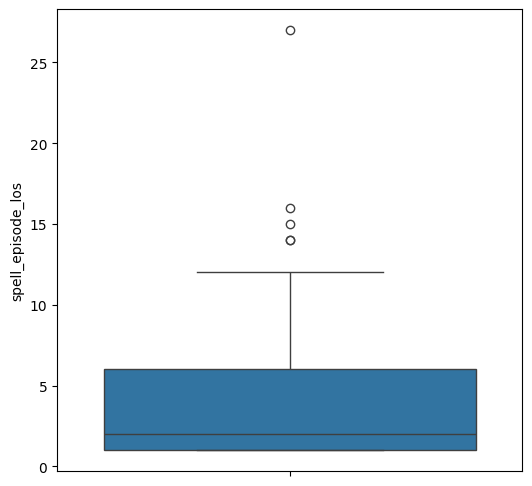

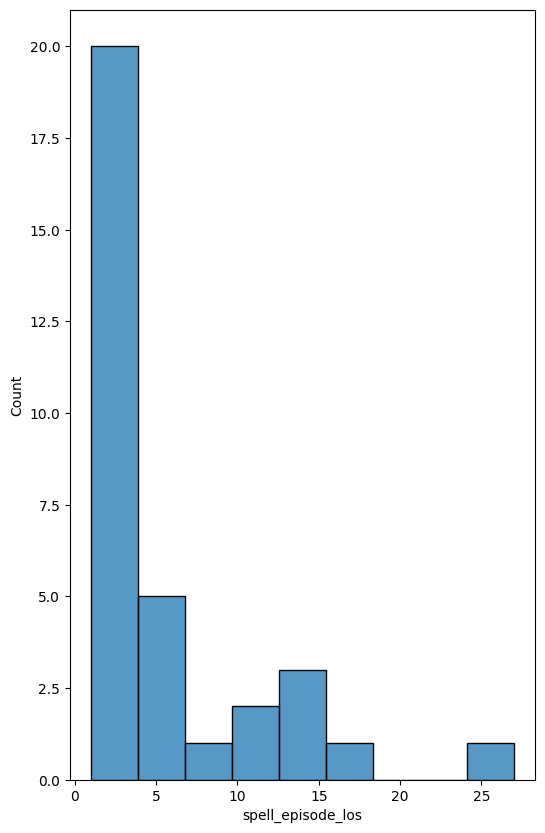

In [13]:
plt.figure(figsize =(6,6))
sns.boxplot(outliers_df['spell_episode_los'])


plt.figure(figsize =(6,10))
sns.histplot(outliers_df['spell_episode_los'])

In [14]:
outliers_df['spell_episode_los'].describe()

count    33.000000
mean      5.151515
std       6.215511
min       1.000000
25%       1.000000
50%       2.000000
75%       6.000000
max      27.000000
Name: spell_episode_los, dtype: float64

Analysis against Patient Demographics

In [15]:
for col in categories['Patient Demographics']:
    print(f"\n{col} ({outliers_df[col].dtype})")
    if outliers_df[col].dtype == object:
        print(f"unique values: {len(outliers_df[col].unique())}")
        print(outliers_df[col].unique())


ethnic_origin_description (object)
unique values: 3
['British (White)' 'Any other White Background'
 'Any other Asian background']

patient_age_on_admission (int64)

patient_age_on_discharge (int64)

sex_national_code (int64)

general_medical_practice_desc (object)
unique values: 23
['PENNYGATE MEDICAL CENTRE' 'SHEVINGTON SURGERY'
 'BROOKMILL MEDICAL CENTRE' 'SHAKESPEARE SURGERY'
 'LONGSHOOT MEDICAL PRACTICE' 'STONEHILL MEDICAL CENTRE' 'MEDICENTRE'
 'HIGH STREET MEDICAL CENTRE' 'EXCEL PRIMARY CARE'
 'BEECH HILL MEDICAL PRACTICE' 'STANDISH MEDICAL PRACTICE'
 'BRADSHAW MEDICAL CENTRE' 'GRASMERE SURGERY' 'PEMBERTON SURGERY'
 'DR TUN & PARTNERS' 'MARUS BRIDGE PRACTICE' 'LEIGH FAMILY PRACTICE'
 'OLD HENRY STREET MED CTR' 'ZAMAN' 'LEIGH SPORTS VILLAGE'
 'SSP HEALTH LIMITED ASHTON MEDICAL CENTRE' 'MARSH GREEN MEDICAL PRACTICE'
 'ECCLESTON MEDICAL CENTRE']

Deprivation Decile (int64)

spell_episode_los (int64)


Heatmap of Patient Demographics against Spell_Episode_Los

<Axes: >

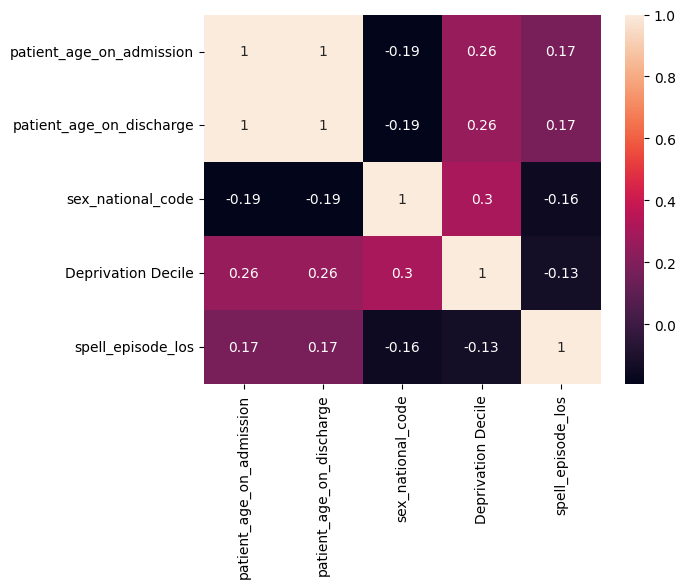

In [16]:
numeric_cols = [
    col for col in categories['Patient Demographics']
    if data[col].dtype != 'object'
]
sns.heatmap(data=outliers_df[numeric_cols].corr(),annot=True)

<p> From the heatmap we can kind of see that patient age has a positive correlation with length of stay and the deprivation decile has a negative correlation. Essentially older patients end up staying long along with people from lower deprivation areas<p>

next we check if the categorical columns have any relation

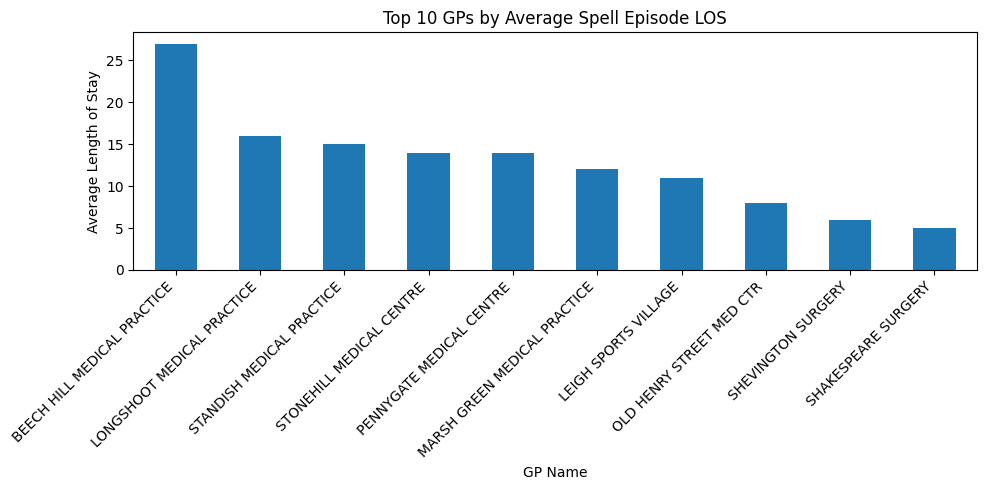

In [17]:
# Group by GP and calculate mean LOS
top10 = (
    outliers_df.groupby('general_medical_practice_desc')['spell_episode_los']
    .max()
    .sort_values(ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(10, 5))
top10.plot(kind='bar')
plt.title("Top 10 GPs by Average Spell Episode LOS")
plt.xlabel("GP Name")
plt.ylabel("Average Length of Stay")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


We will target encode this variable, aka replace it with median of spell_episode_los because its skewed

In [18]:
import pandas as pd

# Calculate mean spell_episode_los per GP
target_mean = outliers_df.groupby('general_medical_practice_desc')['spell_episode_los'].median()

# Map the mean to the original dataframe
outliers_df['gp_target_encoded'] = outliers_df['general_medical_practice_desc'].map(target_mean)

# Check result
print(outliers_df[['general_medical_practice_desc', 'spell_episode_los', 'gp_target_encoded']].head())


     general_medical_practice_desc  spell_episode_los  gp_target_encoded
47        PENNYGATE MEDICAL CENTRE                  5                5.0
1081            SHEVINGTON SURGERY                  6                6.0
7735      BROOKMILL MEDICAL CENTRE                  1                1.0
8988           SHAKESPEARE SURGERY                  5                1.0
9462    LONGSHOOT MEDICAL PRACTICE                 16                9.5


C:\Users\OMNI BOOK\AppData\Local\Temp\ipykernel_19640\1101209622.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['gp_target_encoded'] = outliers_df['general_medical_practice_desc'].map(target_mean)


In [19]:
outliers_df['gp_target_encoded'].value_counts()

gp_target_encoded
1.0     14
5.0      4
14.0     3
2.0      3
9.5      2
10.0     2
6.0      1
3.0      1
8.0      1
11.0     1
12.0     1
Name: count, dtype: int64

We'll do the same for Ethnic Origin Description

In [20]:
import pandas as pd

# Calculate mean spell_episode_los per GP
target_mean = outliers_df.groupby('ethnic_origin_description')['spell_episode_los'].median()

# Map the mean to the original dataframe
outliers_df['ethnic_origin_encoded'] = outliers_df['ethnic_origin_description'].map(target_mean)

# Check result
print(outliers_df[['ethnic_origin_description', 'spell_episode_los', 'ethnic_origin_encoded']].head())


     ethnic_origin_description  spell_episode_los  ethnic_origin_encoded
47             British (White)                  5                    2.0
1081           British (White)                  6                    2.0
7735           British (White)                  1                    2.0
8988           British (White)                  5                    2.0
9462           British (White)                 16                    2.0


C:\Users\OMNI BOOK\AppData\Local\Temp\ipykernel_19640\3174485354.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['ethnic_origin_encoded'] = outliers_df['ethnic_origin_description'].map(target_mean)


In [21]:
outliers_df['ethnic_origin_encoded'].value_counts()

ethnic_origin_encoded
2.0    31
1.0     2
Name: count, dtype: int64

<h3> Patient Demographics Completed <h3>

<h3> Next we'll work with Hospital Demographics </h3>

In [22]:
for col in categories['Hospital Demographics']:
    print(f"\n{col} ({outliers_df[col].dtype})")
    print(f"unique values: {len(outliers_df[col].unique())}")
    print(outliers_df[col].unique())


site_national_code (object)
unique values: 1
['RRF01']

specialty_spec_code (int64)
unique values: 8
[430 300 502 191 180 101 301 104]

ward_code_admission (object)
unique values: 6
['JHRU' 'LE3' 'TR' 'RICH' 'GAST' 'LE2']

ward_code_discharge (object)
unique values: 6
['JHRU' 'SWIN' 'ORR' 'RICH' 'GAST' 'LE2']

specialty_division (object)
unique values: 2
['Medicine' 'Surgery']

specialty_directorate (object)
unique values: 3
['Medicine' 'Womens Health' 'Surgery']

hrg_group (object)
unique values: 11
['Respiratory System' 'Eyes and Periorbita'
 'Female Reproductive System and Assisted Reproduction'
 'Musculoskeletal System' 'Urinary Tract and Male Reproductive System'
 'Skin, Breast and Burns' 'Ear, Nose, Mouth, Throat, Neck and Dental'
 'Digestive System' 'Cardiac Surgery and Primary Cardiac Conditions'
 'Undefined Groups'
 'Immunology, Infectious Diseases and other contacts with Health Services']

hrg_sub_group (object)
unique values: 12
['Thoracic Procedures and Disorders'
 'Eyes a

Drop Columns with Unique Values == 1

In [23]:
# Loop over columns in Hospital Demographics
cols_to_drop = [col for col in categories['Hospital Demographics'] 
                if outliers_df[col].nunique() == 1]

# Drop them
outliers_df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")

Dropped columns: ['site_national_code', 'ward_type_admission', 'ward_type_discharge', 'IP_admission', 'IP_discharge']


C:\Users\OMNI BOOK\AppData\Local\Temp\ipykernel_19640\2134581427.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df.drop(columns=cols_to_drop, inplace=True)


In [24]:
outliers_df.shape

(33, 82)

In [25]:
for col in categories['Hospital Demographics']:
    try:
        print(f"\n{col} ({outliers_df[col].dtype})")
        print(f"unique values: {len(outliers_df[col].unique())}")
        print(outliers_df[col].unique())    
    except Exception as e:
        print("column doesnt exist")
    

column doesnt exist

specialty_spec_code (int64)
unique values: 8
[430 300 502 191 180 101 301 104]

ward_code_admission (object)
unique values: 6
['JHRU' 'LE3' 'TR' 'RICH' 'GAST' 'LE2']

ward_code_discharge (object)
unique values: 6
['JHRU' 'SWIN' 'ORR' 'RICH' 'GAST' 'LE2']

specialty_division (object)
unique values: 2
['Medicine' 'Surgery']

specialty_directorate (object)
unique values: 3
['Medicine' 'Womens Health' 'Surgery']

hrg_group (object)
unique values: 11
['Respiratory System' 'Eyes and Periorbita'
 'Female Reproductive System and Assisted Reproduction'
 'Musculoskeletal System' 'Urinary Tract and Male Reproductive System'
 'Skin, Breast and Burns' 'Ear, Nose, Mouth, Throat, Neck and Dental'
 'Digestive System' 'Cardiac Surgery and Primary Cardiac Conditions'
 'Undefined Groups'
 'Immunology, Infectious Diseases and other contacts with Health Services']

hrg_sub_group (object)
unique values: 12
['Thoracic Procedures and Disorders'
 'Eyes and Periorbita Procedures and Disorde

Again, replace the categorical variables with the target encoding

In [26]:
# Identify categorical columns
categorical_cols = [
    col for col in outliers_df.columns
    if outliers_df[col].dtype == 'object'
]

# Apply target encoding for each categorical column
for col in categorical_cols:
    target_mean = outliers_df.groupby(col)['spell_episode_los'].median()
    outliers_df[f"{col}_target_encoded"] = outliers_df[col].map(target_mean)

C:\Users\OMNI BOOK\AppData\Local\Temp\ipykernel_19640\1384167160.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[f"{col}_target_encoded"] = outliers_df[col].map(target_mean)
C:\Users\OMNI BOOK\AppData\Local\Temp\ipykernel_19640\1384167160.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df[f"{col}_target_encoded"] = outliers_df[col].map(target_mean)
C:\Users\OMNI BOOK\AppData\Local\Temp\ipykernel_19640\1384167160.py:10: SettingWithCopyWarning: 
A value is trying to be set on a 

<h3>Now Doing it for Clinical and Medical</h3>

In [27]:
print(categories['Clinical & Medical'])

['acuity_code', 'attend_dis_description', 'chronic_condition_asthma_flag', 'chronic_condition_cardiovascular_disease_flag', 'chronic_condition_diabetes_flag', 'chronic_condition_hypertension_flag', 'chronic_condition_obesity_flag', 'chronic_condition_respiratory_flag', 'comorbidity_acute_myocardial_infarction_flag', 'comorbidity_cancer_flag', 'comorbidity_cerebral_vascular_accident_flag', 'comorbidity_congestive_heart_failure_flag', 'comorbidity_conncective_tissue_disorder_flag', 'comorbidity_dementia_flag', 'comorbidity_diabetes_complications_flag', 'comorbidity_diabetes_flag', 'comorbidity_hiv_flag', 'comorbidity_liver_disease_flag', 'comorbidity_metastatic_cancer_flag', 'comorbidity_paraplegia_flag', 'comorbidity_peptic_ulcer_flag', 'comorbidity_peripheral_vascular_disease_flag', 'comorbidity_pulmonary_disease_flag', 'comorbidity_renal_disease_flag', 'comorbidity_score', 'comorbidity_severe_liver_disease_flag', 'covid19_diagnosis_flag', 'dementia_diagnosis_flag', 'frailty_score', 'i